# csgoai数据集教程

## 数据工作流
### 1.玩家使用采集脚本上传"id-时间戳.zip"的录制文件
注意：有的玩家可能没有开启权限导致录制的按键都是空的
### 2.我们在本目录下载文件，忽略已有的文件

In [4]:
import oss2
import os,sys
# 阿里云账号AccessKey拥有所有API的访问权限，风险很高。强烈建议您创建并使用RAM用户进行API访问或日常运维，请登录RAM控制台创建RAM用户。
auth = oss2.Auth('xxxxxx', 'OCPCoZZibZkHq075Us3x3XkENgnqLM')
# yourEndpoint填写Bucket所在地域对应的Endpoint。以华东1（杭州）为例，Endpoint填写为https://oss-cn-hangzhou.aliyuncs.com。
# 填写Bucket名称。
bucket = oss2.Bucket(auth, 'oss-cn-beijing.aliyuncs.com', 'csgoai')
# 列举数据
# 列举Bucket下的所有文件。
file_url = []
for obj in oss2.ObjectIterator(bucket):
    url = 'https://csgoai.oss-cn-beijing.aliyuncs.com/'
    path = url + obj.key 
    file_url.append(path)
    print(url + obj.key)
with open('download.txt', 'w') as f:
    f.write('\n'.join(file_url))
!wget -nc -i download.txt

https://csgoai.oss-cn-beijing.aliyuncs.com/1679547341-910698400.zip
https://csgoai.oss-cn-beijing.aliyuncs.com/1679671596-563688500.zip
https://csgoai.oss-cn-beijing.aliyuncs.com/1679672018-278507700.zip
https://csgoai.oss-cn-beijing.aliyuncs.com/gold.coin
https://csgoai.oss-cn-beijing.aliyuncs.com/roth-1679758279-619661300.zip
https://csgoai.oss-cn-beijing.aliyuncs.com/roth-1679831025-978929000.zip
https://csgoai.oss-cn-beijing.aliyuncs.com/roth-1679834724-104942600.zip
https://csgoai.oss-cn-beijing.aliyuncs.com/roth-1679836080-438787700.zip
https://csgoai.oss-cn-beijing.aliyuncs.com/roth-1680278030-262170800.zip
文件 “1679547341-910698400.zip” 已经存在；不获取。

文件 “1679671596-563688500.zip” 已经存在；不获取。

文件 “1679672018-278507700.zip” 已经存在；不获取。

--2023-04-01 10:44:30--  https://csgoai.oss-cn-beijing.aliyuncs.com/gold.coin
正在解析主机 csgoai.oss-cn-beijing.aliyuncs.com (csgoai.oss-cn-beijing.aliyuncs.com)... 59.110.190.28
正在连接 csgoai.oss-cn-beijing.aliyuncs.com (csgoai.oss-cn-beijing.aliyuncs.com)|59.1

### 3.解压下载下来的新数据，并忽略已解压数据

In [18]:
! for file in *.zip; do unzip -jn "$file" -d "./data/${file%.*}"; done

Archive:  1678773194-747264600.zip
Archive:  1678773479-138390300.zip
Archive:  1679547341-910698400.zip
Archive:  1679671596-563688500.zip
Archive:  1679672018-278507700.zip
Archive:  roth-1679758279-619661300.zip
Archive:  roth-1679831025-978929000.zip
Archive:  roth-1679834724-104942600.zip
Archive:  roth-1679836080-438787700.zip
Archive:  roth-1680278030-262170800.zip


### 4.运行数据OCR，提取玩家存活时的POV图片
脚本会读取./data/目录下的文件夹，然后5进程识别每个目录下的图片。

这里面涉及一些对玩家存活状态和死亡状态的OCR清洗规则。

不同玩家的录制，因为其服务器不一样的缘故，可能要增加更多的规则。

#### 基本逻辑：

对每局开始的关键词，记录为1，结束关键词记录为2，其余为0. 然后提取1-2中间的图片。

#### 输出：

生成./cleaned_data/文件名.txt 里面包含存活状态相对路径的每一张图片。

#### 注意，
- 一个录制文件中，大概率玩家打了很多局，所以txt文件中包含多次录制而没有特殊标记。
- 如果清洗规则没写好，那么就会出现一个视频识别空文件.txt的情况。

#### todo：
- OCR清洗速度太慢，即使采用并行的方式，速度也不理想，如何优化OCR性能？
- OCR的精准度堪忧，很多时候会错误识别
- 需要根据不同的数据来添加“开始帧”“结束帧”的清洗规则

有两个脚本，一个是单进程ocr_clean.py 另一个是多进程ocr_clean_parallel.py, 多进程没有显著的快可是复杂些。
l参数表示清洗最近的(这个功能可能需要改进，因为是按文件名sort的不是按时间戳)。
n参数表示清洗指定文件夹名

In [8]:
!python ocr_clean_parallel.py -l 

num of folders: 10
cleaning:  ./data/roth-1680278030-262170800 | num of files: 9585 | video length: 00:07:59
[#################################################-] 100.0% 00:06:18 9584 
 cleaned to : ./cleaned_data/roth-1680278030-262170800.txt



### 5. OCR清洗质量检查
没有识别出玩家存活帧的文件会被ocr脚本写在cleaned_data/null_cleaned_files.txt

一般来说遇到这种情况需要你手动点开原始图挨个debug。
todo：
- 一种更方便的方式来debug空文件？

In [11]:
! cat cleaned_data/null_cleaned_files.txt

./cleaned_data/roth-1679834724-104942600.txt
./cleaned_data/roth-1679831025-978929000.txt
./cleaned_data/1679547341-910698400.txt
./cleaned_data/1679671596-563688500.txt
./cleaned_data/roth-1679836080-438787700.txt
./cleaned_data/1679672018-278507700.txt

### 6. 图像和动作标签匹配
功能：
- 用清洗后的./cleaned_data/录制名.txt中的图片时间戳 匹配 ./data/录制名/录制名.json中的wasd等动作行为。生成./cleaned_data/录制名_labelled.csv
- 鼠标会前后做差计算出移动增量，然后按照tim Pearce的离散列表找一个最近的（也就是做离散化）

todo：
- 离散化的数值分布可能不是很合适，我们应该找一种直觉上可以方便表征玩家动作让ai学习的（自己画图统计）
- mouse_x mouse_y 的定义不是很清楚，坐标原点一般来说在右上角。竖着是x还是横着是x？鼠标需要严格注意，目前没有梳理清楚！

In [12]:
!python match_labels.py

json_files:
 ./data/roth-1679834724-104942600/roth-1679834724-104942600.json
./data/roth-1679831025-978929000/roth-1679831025-978929000.json
./data/1679547341-910698400/1679547341-910698400.json
./data/1678773479-138390300/1678773479-138390300.json
./data/roth-1679758279-619661300/roth-1679758279-619661300.json
./data/1678773194-747264600/1678773194-747264600.json
./data/1679671596-563688500/1679671596-563688500.json
./data/roth-1680278030-262170800/roth-1680278030-262170800.json
./data/roth-1679836080-438787700/roth-1679836080-438787700.json
./data/1679672018-278507700/1679672018-278507700.json
txt files with no death: 
 ./cleaned_data/roth-1679834724-104942600.txt
./cleaned_data/roth-1679831025-978929000.txt
./cleaned_data/1679547341-910698400.txt
./cleaned_data/1678773479-138390300.txt
./cleaned_data/roth-1679758279-619661300.txt
./cleaned_data/1678773194-747264600.txt
./cleaned_data/1679671596-563688500.txt
./cleaned_data/roth-1680278030-262170800.txt
./cleaned_data/roth-1679836080

### 7.打包数据集为h5格式（包含图片和标签）
h5py是Hierarchical Data Format version 5 (HDF5)数据集格式在python中的实现。

打包后会输出到./h5_data/csgo_data_new.h5

注，这里包含resize环节：（125, 200, 3） 

回合行为异常是检测到所有action都是0，一般情况是因为玩家录制的时候没有开管理员权限，这种情况把对应压缩包mv 成名字.zip.bak就好。因为我们要保留本地数据，用来对录制员的奖励。


这种文件针对训练读取做了很强大的优化，让它从磁盘里读访问很快。
```python
f = h5py.File(path, 'r')
datas = f["data"]
labels = f["label"]
ep1_imgs = datas[0]
ep1_actions = labels[0] # (7, 1100, 125, 200, 3) 回合，帧数，图片尺度
````
这样就可以很方便的把数据读出来，同时很快。

In [14]:
!python pack_h5_dataset_parallel.py

==========================开始处理：1678773194-747264600_labelled.csv=======================================
preprocessing:  2023-04-01 11:38:28
libpng error: Read Error
None image at: /disk3/csgo_ai_data/./data/./1678773194-747264600/1678773232-344548700.png 

img_array_size = 28.97 MB
done preprocessing:  2023-04-01 11:38:30  took time:00:00:01
max time gap is 1s, saving as complete match
-------------------------添加第1回合-405帧---------------------------
sample length is 405, appending to 1100
==========================开始处理：1678773479-138390300_labelled.csv=======================================
preprocessing:  2023-04-01 11:38:30
img_array_size = 1.50 MB
done preprocessing:  2023-04-01 11:38:30  took time:00:00:00
max time gap is 1s, saving as complete match
-------------------------添加第2回合-21帧---------------------------
回合行为异常，不添加
==========================开始处理：roth-1679758279-619661300_labelled.csv=======================================
preprocessing:  2023-04-01 11:38:30
img_array_size = 

### 7.打包后的数据集质量检查
这个脚本有待加强，里面对玩家鼠标的逻辑还没有搞清楚。
鼠标的可视化也很粗糙。


KeyboardInterrupt



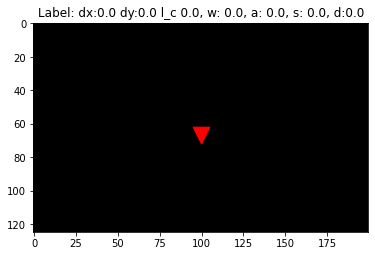

In [17]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

path = './h5_data/csgo_data_new.h5'
f = h5py.File(path, 'r')
data = f["data"]
label = f["label"]
shape = data.shape
# 选择一个回合
ep = 0
data = data[ep]
label = label[ep]
print(f'总共有{shape[0]}个回合, 数据shape为{shape}, 选择查看第{ep}回合')

# 在图像中央创建箭头
x_center = data.shape[2] // 2
y_center = data.shape[1] // 2

# visualize numpy array 
for i in range(data.shape[0]):
    clear_output(wait=True)
    plt.clf()
    # 对label进行处理
    mouse_x,mouse_y,click_left,click_right,scroll,w,a,s,d,r,q,e,b,k_1,k_2,k_3,k_4,k_5,k_6,k_7,k_8,k_9,k_0,shift,space,ctrl = label[i]

    # 处理箭头
    vector_x = mouse_x *10 #* (x_center // 4)  # 向量长度为图像宽度的四分之一
    vector_y = mouse_y *10 #* (y_center // 4)  # 向量长度为图像高度的四分之一
    plt.arrow(x_center, y_center, vector_x, vector_y,
          color="r", head_width=10, head_length=10)
    
    plt.imshow(data[i])
    plt.title(f"Label: dx:{mouse_x} dy:{mouse_y} l_c {click_left}, w: {w}, a: {a}, s: {s}, d:{d}")
    display(plt.gcf())